# We load our libs

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import pandas_profiling

%matplotlib notebook

In [2]:
pd.set_option('display.max_columns', 300)

# We load our datasets

In [3]:
train_full = pd.read_csv('./kaggle-house-prices-train.csv')
kaggle = pd.read_csv('./kaggle-house-prices-test.csv')

In [4]:
if not os.path.exists('./predictions'):
    os.makedirs('./predictions')

In [42]:
project = 'house_prices'

dossier_predictions = './predictions/'
version = 'v1.4'

In [43]:
csv_suffix = version + '.csv'

filename_prediction = 'kaggle_prediction_house_' + csv_suffix

Nous choisissons la feature "Neighborhood" en sus de la variable "Surface" <br />
On crée la variable "Surface":

In [8]:
train_full['Surface'] = train_full['TotalBsmtSF'] + train_full['GrLivArea']
kaggle['Surface'] = kaggle['TotalBsmtSF'] + kaggle['GrLivArea']

On élimine les lignes avec des vameurs manquantes pour "Neighborhood"

In [9]:
train_full = train_full.fillna(0)
kaggle = kaggle.fillna(0)

On plot le prix en fonction de la surface totale en colorant par "Neighborhood"

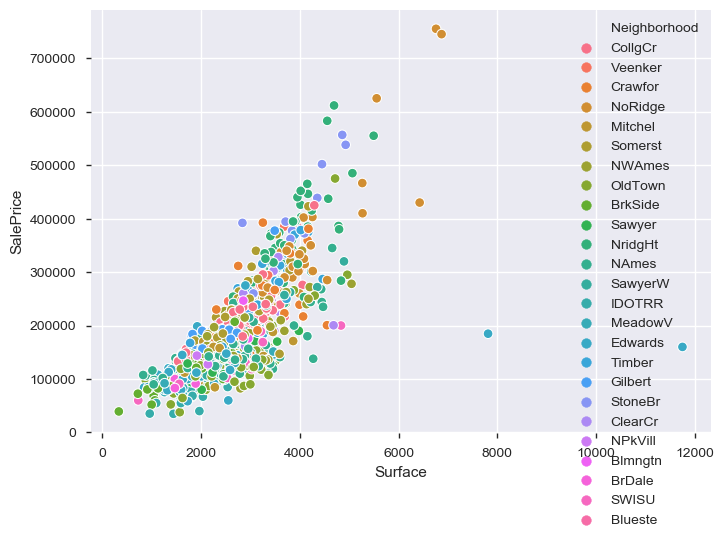

In [10]:
sns.scatterplot(x=train_full['Surface'],
                y=train_full['SalePrice'], hue=train_full['Neighborhood'])

Suite au scatterplot, on choisi de supprimer les données dont la surface est supérieure à 7000

In [11]:
kept_surface = train_full['Surface'] < 7000
# train_full = train_full[kept_surface][['SalePrice', 'GrLivArea', 'Surface', 'Neighborhood']]
train_full = train_full[kept_surface]

Pour intégrer les variables catégorielles, on peut les "séparer" en autant de colones que de catégorie par variables remplies par des `0` si la catégrie ne match pas et `1` si la catégorie match... <br />
fonction `get_dummies` de Pandas

In [12]:
train_full_save = pd.DataFrame()
train_full_save['Neighborhood'] = train_full['Neighborhood']
kaggle_save = pd.DataFrame()
kaggle_save['Neighborhood'] = kaggle['Neighborhood']

train_full = pd.get_dummies(train_full)
train_full['Neighborhood'] = train_full_save['Neighborhood']
kaggle = pd.get_dummies(kaggle)
kaggle['Neighborhood'] = kaggle_save['Neighborhood']

We drop the columns with a lot of empty value

In [13]:
train_full.drop(['LowQualFinSF', 'BsmtHalfBath', '3SsnPorch', 'PoolArea', 'MiscVal' ], axis=1)
kaggle.drop(['LowQualFinSF', 'BsmtHalfBath', '3SsnPorch', 'PoolArea', 'MiscVal' ], axis=1)
train_full.head(5)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,Surface,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_0,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,...,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_0,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_0,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_0,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_0,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_0,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_0,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_0,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_0,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_0,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_0,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_0,GarageQual_Ex,GarageQual_Fa,GarageQua

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    train_full, train_full['SalePrice'], test_size=0.2, random_state=42)

In [15]:
def calc_SmPrice(row):
    row['SmPrice'] = row['SalePrice']/row['GrLivArea']
    return row['SmPrice']

def get_SmPrice(df):
    nb_sm_prices = dict()
    for nb in df.Neighborhood.unique():
        rows = df.loc[df['Neighborhood']==nb]
        rows['SmPrice'] = rows.apply(calc_SmPrice, axis=1)
        nb_sm_prices.update({str(nb): rows['SmPrice'].mean()})
    return nb_sm_prices

def set_NbSmPrice(row):
    row['NbSmPrice'] = smprices.get(row['Neighborhood'])
    return row['NbSmPrice']

In [16]:
smprices = get_SmPrice(X_train)
X_train['NbSmPrice'] = X_train.apply(set_NbSmPrice, axis=1)

C:\Users\utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
X_test['NbSmPrice'] = X_test.apply(set_NbSmPrice, axis=1)

C:\Users\utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
kaggle['NbSmPrice'] = kaggle.apply(set_NbSmPrice, axis=1)

In [19]:
X_train = X_train.drop(['SalePrice', 'Neighborhood'], axis=1)

In [20]:
X_test = X_test.drop(['SalePrice', 'Neighborhood'], axis=1)

In [21]:
# X_train.to_csv('./datasets/x_train_formatted.csv', index=False)
# X_test.to_csv('./datasets/x_test_formatted.csv', index=False)

In [22]:
# y_train.to_csv('./datasets/y_train.csv', index=False)
# y_test.to_csv('./datasets/y_test.csv', index=False)

In [23]:
kaggle = kaggle.drop(['Neighborhood'], axis=1)

In [24]:
X_train

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Surface,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_0,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,...,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_0,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_0,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_0,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_0,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_0,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_0,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_0,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_0,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_0,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_0,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_0,GarageQual_Ex,GarageQual_Fa

In [25]:
# define the model
def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(X_train.shape[1]*2, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(X_train.shape[1]*2, kernel_initializer='normal', activation='relu'))
    model.add(Dense(X_train.shape[1]*1, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [26]:
missing_col = list(set(X_train.columns) - set(kaggle.columns))

for col in missing_col:
    kaggle[col] = 0
kaggle = kaggle[X_train.columns]

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [28]:
X_test = scaler.transform(X_test)

In [29]:
kaggle = scaler.transform(kaggle)

In [30]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)
y_scaler = StandardScaler()
y_train_log = np.array(y_train_log).reshape(-1, 1)
y_test_log = np.array(y_test_log).reshape(-1, 1)

In [31]:
y_scaler.fit(y_train_log)
y_train_log_scaled = y_scaler.transform(y_train_log)
y_test_log_scaled = y_scaler.transform(y_test_log)

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# evaluate model
estimator = KerasRegressor(build_fn=larger_model, epochs=100, batch_size=100)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, X_train, y_train_log_scaled, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Using TensorFlow backend.


Epoch 1/100
1049/1049 [==============================] - 3s 3ms/sample - loss: 0.4383
Epoch 2/100
1049/1049 [==============================] - 0s 131us/sample - loss: 0.1728
Epoch 3/100
1049/1049 [==============================] - 0s 134us/sample - loss: 0.0673
Epoch 4/100
1049/1049 [==============================] - 0s 139us/sample - loss: 0.0436
Epoch 5/100
1049/1049 [==============================] - 0s 134us/sample - loss: 0.0259
Epoch 6/100
1049/1049 [==============================] - 0s 156us/sample - loss: 0.0154
Epoch 7/100
1049/1049 [==============================] - 0s 143us/sample - loss: 0.0103
Epoch 8/100
1049/1049 [==============================] - 0s 132us/sample - loss: 0.0070
Epoch 9/100
1049/1049 [==============================] - 0s 136us/sample - loss: 0.0053
Epoch 10/100
1049/1049 [==============================] - 0s 133us/sample - loss: 0.0046
Epoch 11/100
1049/1049 [==============================] - 0s 140us/sample - loss: 0.0050
Epoch 12/100
1049/1049 [========

1049/1049 [==============================] - 0s 141us/sample - loss: 4.5051e-04
Epoch 83/100
1049/1049 [==============================] - 0s 138us/sample - loss: 4.9248e-04
Epoch 84/100
1049/1049 [==============================] - 0s 151us/sample - loss: 5.3082e-04
Epoch 85/100
1049/1049 [==============================] - 0s 137us/sample - loss: 4.1537e-04
Epoch 86/100
1049/1049 [==============================] - 0s 137us/sample - loss: 3.8383e-04
Epoch 87/100
1049/1049 [==============================] - 0s 140us/sample - loss: 4.5359e-04
Epoch 88/100
1049/1049 [==============================] - 0s 132us/sample - loss: 4.1448e-04
Epoch 89/100
1049/1049 [==============================] - 0s 137us/sample - loss: 5.3114e-04
Epoch 90/100
1049/1049 [==============================] - 0s 138us/sample - loss: 5.2063e-04
Epoch 91/100
1049/1049 [==============================] - 0s 152us/sample - loss: 5.4762e-04
Epoch 92/100
1049/1049 [==============================] - 0s 147us/sample - loss: 7

Epoch 63/100
1049/1049 [==============================] - 0s 148us/sample - loss: 0.0010
Epoch 64/100
1049/1049 [==============================] - 0s 140us/sample - loss: 0.0013
Epoch 65/100
1049/1049 [==============================] - 0s 139us/sample - loss: 9.5882e-04
Epoch 66/100
1049/1049 [==============================] - 0s 136us/sample - loss: 0.0012
Epoch 67/100
1049/1049 [==============================] - 0s 134us/sample - loss: 0.0011
Epoch 68/100
1049/1049 [==============================] - 0s 140us/sample - loss: 0.0012
Epoch 69/100
1049/1049 [==============================] - 0s 136us/sample - loss: 0.0015
Epoch 70/100
1049/1049 [==============================] - 0s 153us/sample - loss: 0.0028
Epoch 71/100
1049/1049 [==============================] - 0s 143us/sample - loss: 0.0022
Epoch 72/100
1049/1049 [==============================] - 0s 134us/sample - loss: 0.0035
Epoch 73/100
1049/1049 [==============================] - 0s 134us/sample - loss: 0.0019
Epoch 74/100
1049

1049/1049 [==============================] - 0s 145us/sample - loss: 0.0012
Epoch 44/100
1049/1049 [==============================] - 0s 143us/sample - loss: 9.5812e-04
Epoch 45/100
1049/1049 [==============================] - 0s 156us/sample - loss: 0.0011
Epoch 46/100
1049/1049 [==============================] - 0s 146us/sample - loss: 0.0011
Epoch 47/100
1049/1049 [==============================] - 0s 144us/sample - loss: 0.0015
Epoch 48/100
1049/1049 [==============================] - 0s 142us/sample - loss: 0.0017
Epoch 49/100
1049/1049 [==============================] - 0s 154us/sample - loss: 0.0011
Epoch 50/100
1049/1049 [==============================] - 0s 140us/sample - loss: 8.8468e-04
Epoch 51/100
1049/1049 [==============================] - 0s 145us/sample - loss: 6.0756e-04
Epoch 52/100
1049/1049 [==============================] - 0s 136us/sample - loss: 6.0781e-04
Epoch 53/100
1049/1049 [==============================] - 0s 153us/sample - loss: 9.9084e-04
Epoch 54/100
1

Epoch 34/100
1050/1050 [==============================] - 0s 150us/sample - loss: 0.0019
Epoch 35/100
1050/1050 [==============================] - 0s 142us/sample - loss: 0.0016
Epoch 36/100
1050/1050 [==============================] - 0s 134us/sample - loss: 0.0022
Epoch 37/100
1050/1050 [==============================] - 0s 139us/sample - loss: 0.0019
Epoch 38/100
1050/1050 [==============================] - 0s 141us/sample - loss: 0.0018
Epoch 39/100
1050/1050 [==============================] - 0s 140us/sample - loss: 0.0018
Epoch 40/100
1050/1050 [==============================] - 0s 151us/sample - loss: 0.0023
Epoch 41/100
1050/1050 [==============================] - 0s 159us/sample - loss: 0.0035
Epoch 42/100
1050/1050 [==============================] - 0s 159us/sample - loss: 0.0031
Epoch 43/100
1050/1050 [==============================] - 0s 155us/sample - loss: 0.0048
Epoch 44/100
1050/1050 [==============================] - 0s 140us/sample - loss: 0.0038
Epoch 45/100
1050/105

Epoch 24/100
1050/1050 [==============================] - 0s 154us/sample - loss: 0.0013
Epoch 25/100
1050/1050 [==============================] - 0s 145us/sample - loss: 0.0014
Epoch 26/100
1050/1050 [==============================] - 0s 139us/sample - loss: 0.0011
Epoch 27/100
1050/1050 [==============================] - 0s 135us/sample - loss: 0.0011
Epoch 28/100
1050/1050 [==============================] - 0s 140us/sample - loss: 0.0012
Epoch 29/100
1050/1050 [==============================] - 0s 144us/sample - loss: 0.0013
Epoch 30/100
1050/1050 [==============================] - 0s 166us/sample - loss: 0.0011
Epoch 31/100
1050/1050 [==============================] - 0s 145us/sample - loss: 7.4085e-04
Epoch 32/100
1050/1050 [==============================] - 0s 149us/sample - loss: 0.0010
Epoch 33/100
1050/1050 [==============================] - 0s 145us/sample - loss: 7.3106e-04
Epoch 34/100
1050/1050 [==============================] - 0s 144us/sample - loss: 8.3517e-04
Epoch 35/

Epoch 15/100
1050/1050 [==============================] - 0s 149us/sample - loss: 0.0027
Epoch 16/100
1050/1050 [==============================] - 0s 134us/sample - loss: 0.0034
Epoch 17/100
1050/1050 [==============================] - 0s 137us/sample - loss: 0.0043
Epoch 18/100
1050/1050 [==============================] - 0s 144us/sample - loss: 0.0045
Epoch 19/100
1050/1050 [==============================] - 0s 140us/sample - loss: 0.0071
Epoch 20/100
1050/1050 [==============================] - 0s 159us/sample - loss: 0.0113
Epoch 21/100
1050/1050 [==============================] - 0s 144us/sample - loss: 0.0141
Epoch 22/100
1050/1050 [==============================] - 0s 139us/sample - loss: 0.0082
Epoch 23/100
1050/1050 [==============================] - 0s 141us/sample - loss: 0.0056
Epoch 24/100
1050/1050 [==============================] - 0s 135us/sample - loss: 0.0041
Epoch 25/100
1050/1050 [==============================] - 0s 165us/sample - loss: 0.0023
Epoch 26/100
1050/105

Epoch 6/100
1050/1050 [==============================] - 0s 143us/sample - loss: 0.0178
Epoch 7/100
1050/1050 [==============================] - 0s 162us/sample - loss: 0.0126
Epoch 8/100
1050/1050 [==============================] - 0s 158us/sample - loss: 0.0087
Epoch 9/100
1050/1050 [==============================] - 0s 148us/sample - loss: 0.0065
Epoch 10/100
1050/1050 [==============================] - 0s 148us/sample - loss: 0.0049
Epoch 11/100
1050/1050 [==============================] - 0s 146us/sample - loss: 0.0039
Epoch 12/100
1050/1050 [==============================] - 0s 149us/sample - loss: 0.0030
Epoch 13/100
1050/1050 [==============================] - 0s 163us/sample - loss: 0.0033
Epoch 14/100
1050/1050 [==============================] - 0s 152us/sample - loss: 0.0024
Epoch 15/100
1050/1050 [==============================] - 0s 152us/sample - loss: 0.0018
Epoch 16/100
1050/1050 [==============================] - 0s 156us/sample - loss: 0.0015
Epoch 17/100
1050/1050 [=

Epoch 97/100
1050/1050 [==============================] - 0s 139us/sample - loss: 0.0037
Epoch 98/100
1050/1050 [==============================] - 0s 167us/sample - loss: 0.0040
Epoch 99/100
1050/1050 [==============================] - 0s 160us/sample - loss: 0.0039
Epoch 100/100
116/116 [==============================] - 0s 3ms/sample - loss: 0.0691
Baseline: -0.10 (0.03) MSE


In [33]:
history = estimator.fit(X_train, y_train_log_scaled)
y_predict = estimator.predict(X_test)


Epoch 1/100
1166/1166 [==============================] - 2s 1ms/sample - loss: 0.5735
Epoch 2/100
1166/1166 [==============================] - 0s 170us/sample - loss: 0.1373
Epoch 3/100
1166/1166 [==============================] - 0s 151us/sample - loss: 0.0686
Epoch 4/100
1166/1166 [==============================] - 0s 149us/sample - loss: 0.0380
Epoch 5/100
1166/1166 [==============================] - 0s 146us/sample - loss: 0.0261
Epoch 6/100
1166/1166 [==============================] - 0s 153us/sample - loss: 0.0176
Epoch 7/100
1166/1166 [==============================] - 0s 148us/sample - loss: 0.0138
Epoch 8/100
1166/1166 [==============================] - 0s 146us/sample - loss: 0.0101
Epoch 9/100
1166/1166 [==============================] - 0s 145us/sample - loss: 0.0074
Epoch 10/100
1166/1166 [==============================] - 0s 140us/sample - loss: 0.0058
Epoch 11/100
1166/1166 [==============================] - 0s 256us/sample - loss: 0.0043
Epoch 12/100
1166/1166 [========

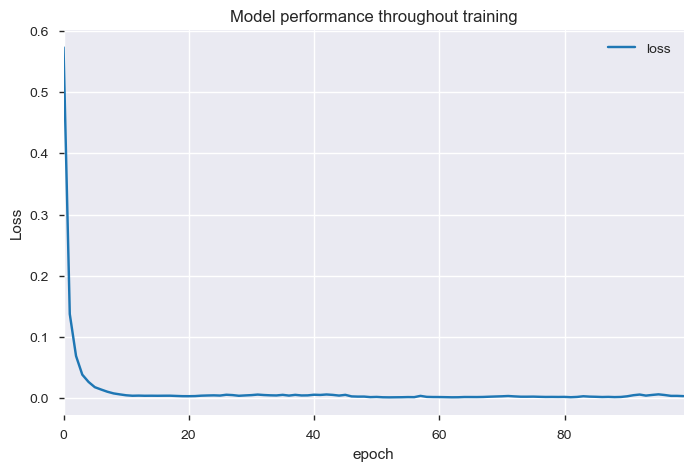

RMSLE :  0.13281027502910078
MAE :  15629.35866598887


In [34]:
y_predict_rescaled = np.exp(y_scaler.inverse_transform(y_predict))

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.title('Model performance throughout training')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

print('RMSLE : ', np.sqrt(metrics.mean_squared_log_error(y_test, y_predict_rescaled)))
print('MAE : ', metrics.mean_absolute_error(y_test, y_predict_rescaled))

In [35]:
sub = pd.DataFrame()
ids = [i+1461 for i in range(1459)]
sub['Id'] = ids

In [36]:
sub = pd.DataFrame()
ids = [i+1461 for i in range(1459)]
sub['Id'] = ids

In [37]:
y_k_predict = estimator.predict(kaggle)


In [38]:
sub['SalePrice'] = np.exp(y_scaler.inverse_transform(y_k_predict))

In [44]:
sub.to_csv(dossier_predictions+filename_prediction, index=False)